<a href="https://colab.research.google.com/github/zahra-ziaei/teaching-python-undergrade/blob/main/Homework_2_(answers).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l==0.16.1
!pip install -U mxnet-cu101==1.7.0

Requirement already up-to-date: mxnet-cu101==1.7.0 in /usr/local/lib/python3.6/dist-packages (1.7.0)


In [ ]:
from d2l import mxnet as d2l
from mxnet import gluon, init, npx, autograd, np
from mxnet.gluon import nn
npx.set_np()
import matplotlib.pyplot as plt

# 1. Logistic Regression for Binary Classification (1.5 points)

In multiclass classification we typically use the exponential model 

$$p(y|\mathbf{o}) = \mathrm{softmax}(\mathbf{o})_y = \frac{\exp(o_y)}{\sum_{y'} \exp(o_{y'})}$$

1. Show that this parametrization has a spurious degree of freedom. That is, show that both $\mathbf{o}$ and $\mathbf{o} + c$ with $c \in \mathbb{R}$ lead to the same probability estimate.

2. For binary classification, i.e. whenever we have only two classes $\{-1, 1\}$, we can arbitrarily set $o_{-1} = 0$. Using the shorthand $o = o_1$ show that this is equivalent to 

$$p(y=1|o) = \frac{1}{1 + \exp(-o)}$$

3. Show that the log-likelihood loss (often called logistic loss) for labels $y \in \{-1, 1\}$ is thus given by 

$$-\log p(y|o) = \log (1 + \exp(-y \cdot o))$$

4. Show that for $y = 1$ the logistic loss asymptotes to $o$ for $o \to \infty$ and to $\exp(o)$ for $o \to -\infty$. 

1.1 
$$ \frac{\exp(o_y + c)}{\sum_{y'} \exp(o_{y'} + c)} = \frac{\exp(c)\exp(o_y)}{\exp(c)\sum_{y'} \exp(o_{y'})} = \frac{\exp(o_y)}{\sum_{y'} \exp(o_{y'})}$$

1.2 
$$p(y = 1 | o_{-1} = 0, o_1 = 0) = \frac{\exp(o_1)}{\exp(o_1) + \exp(o_{-1})} = \frac{\exp(o)}{\exp(o) + \exp(0)} = \frac{\exp(-o)}{\exp(-o)}\frac{\exp(o)}{\exp(o) + 1} = \frac{1}{1 + \exp(-o)}$$

1.3
$$p(y = -1 | o) = 1 - p(y = 1 | o) = 1 - \frac{1}{1 + \exp(-o)} = 1 - \frac{\exp(o)}{\exp(o)}\frac{1}{1 + \exp(-o)} = 1 - \frac{\exp(o)}{\exp(o) + 1} = \frac{1}{1 + \exp(o)}$$

$$p(y | o) = \frac{1}{1 + \exp(-y \cdot o)}$$

$$-\log p(y | o) = \log(1 + \exp(-y \cdot o))$$

1.4

$$\lim_{o \rightarrow \infty} \log(1 + \exp(-o)) = \log(1 + \lim_{o \rightarrow \infty} \exp(-o)) = \log(1) = 0$$

$$\lim_{o \rightarrow -\infty} \log(1 + \exp(-o)) = \log(1 + \lim_{o \rightarrow \infty} \exp(o)) = \infty$$



# 2. Logistic Regression and Autograd (1 point)

1. Implement the binary logistic loss $l(y,o) = \log (1 + \exp(-y \cdot o))$ in Gluon
1. Plot its values for $y \in \{-1, 1\}$ over the range of $o \in [-5, 5]$.
1. Plot its derivative with respect to $o$ for $y \in \{-1, 1\}$ and for $o \in [-5, 5]$ using 'autograd'.

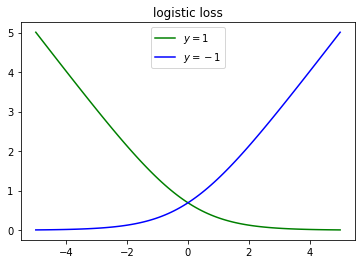

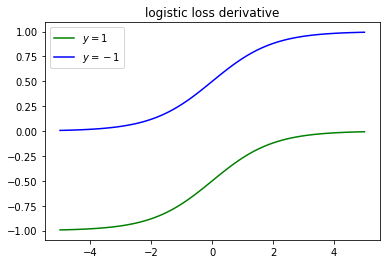

In [ ]:
def loss(y,o):
    o.attach_grad()
    with autograd.record():
        l = np.log(np.exp(-y*o)+1)
    l.backward()
    return l

o = np.linspace(-5,5, 100)
plt.title("logistic loss")
plt.plot(o.asnumpy(), loss(1.0, o).asnumpy(), color='g', label="$y=1$")
l_diff_1 = o.grad.asnumpy()
plt.plot(o.asnumpy(), loss(-1.0, o).asnumpy(), color='b', label="$y=-1$")
l_diff_minus_1 = o.grad.asnumpy()
plt.legend()
plt.show()
plt.title("logistic loss derivative")
plt.plot(o.asnumpy(), l_diff_1, color='g', label="$y=1$")
plt.plot(o.asnumpy(), l_diff_minus_1, color='b', label="$y=-1$")
plt.legend()
plt.show()

# 3. T-shirt vs. Trouser classification (1.5 points)

1. Implement a logistic regression model on the Fashion MNIST datasets that classifies between t-shirts and trousers, rather than all 10 of the classes. Feel free to use the [softmax regression code from the textbook](http://d2l.ai/chapter_linear-networks/softmax-regression-scratch.html), but use the binary logistic loss you defined above (which assumes that the labels are -1 or 1) rather than a softmax cross-entropy loss. This will require creating custom version of the `d2l.load_data_fashion_mnist` that removes any examples that are not t-shirts or trousers.
2. After implementing this model and getting it to work, try changing the learning rate and weight initialization scale. Can you get the model to train more quickly? What values of these hyperparameters result in bad models/poor training dynamics?

*Note*: Don't forget to change the runtime type to "GPU" to speed things up!

In [ ]:
def load_tshirt_trouser_dataset(batch_size):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    dataset = gluon.data.vision
    trans = [dataset.transforms.ToTensor()]
    trans = dataset.transforms.Compose(trans)
    mnist_train = dataset.FashionMNIST(train=True).transform_first(trans)
    mnist_train = mnist_train.filter(lambda x: x[1] < 2)
    mnist_test = dataset.FashionMNIST(train=False).transform_first(trans)
    mnist_test = mnist_test.filter(lambda x: x[1] < 2)
    return (gluon.data.DataLoader(mnist_train, batch_size, shuffle=True,
                                  num_workers=d2l.get_dataloader_workers()),
            gluon.data.DataLoader(mnist_test, batch_size, shuffle=False,
                                  num_workers=d2l.get_dataloader_workers()))

In [ ]:
batch_size = 256
train_iter, test_iter = load_tshirt_trouser_dataset(batch_size)

In [ ]:
net = nn.Sequential()
net.add(nn.Dense(1))
net.initialize(init.Normal(sigma=0.1))

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

def loss(y, o):
    return np.log(np.exp(-(2*y - 1)*o.flatten()) + 1)

for epoch in range(10):
    for X, y in train_iter:
        with autograd.record():
            logit = net(X)
            l = loss(y, logit)
        l.backward()
        trainer.step(X.shape[0])
    accuracy = 0.
    for n, (X, y) in enumerate(test_iter):
        accuracy += np.mean((net(X) > 0).flatten().astype(np.int32) == y)
    print(accuracy/(n + 1))

0.9655574
0.96811146
0.9752855
0.97979265
0.9817458
0.9812575
0.9793044
0.9823468
0.98283505
0.9823468
